

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

# Load required packages

In [1]:
import random
import os
import numpy as np
import json
import corner
import random

import pandas as pd
import datetime
import scipy
import matplotlib.dates as mdates
import matplotlib
import math
import xarray as xr
import emcee
import matplotlib.pyplot as plt
import datetime

from covid19model.optimization import objective_fcns,pso
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD_google
from covid19model.models.time_dependant_parameter_fncs import google_lockdown, ramp_fun, contact_matrix
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected, _apply_tick_locator 
from covid19model.visualization.optimization import plot_fit, traceplot


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Load data

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
levels = initN.size

In [3]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail(2)

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-11-17,6240,1356,372,670,5507,118,0.0,9.0,14,45,50
2020-11-18,5897,1325,353,562,5298,18,0.0,1.0,4,8,5


In [4]:
df_google = google.get_google_mobility_data(update=False, plot=False)
df_google.tail(2)

,retail_recreation,grocery,parks,transport,work,residential
date,,,,,,
2020-11-14,-57.0,-10.0,47.0,-38.0,-22.0,13.0
2020-11-15,-65.0,-20.0,-27.0,-50.0,-23.0,11.0


In [ ]:

# def switch_beta(t,param,samples_dict):
#     if t < pd.to_datetime('2020-05-04'):
#         return np.random.choice(samples_dict['beta'],1,replace=False)
#     elif pd.to_datetime('2020-05-04') < t <= pd.to_datetime('2020-09-01'):
#         return np.random.choice(samples_dict['beta_summer'],1,replace=False)
#     else:
#         return np.random.choice(samples_dict['beta'],1,replace=False)

# Wave 2: September 2020 - present

## Recalibrate ramp as final calibration step

In [5]:
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/google/initial_states_2020-09-01.json', 'r') as fp:
    initial_states = json.load(fp)    

In [7]:
# Start of data collection
start_data = '2020-09-01'
# Start data of recalibration ramp
start_calibration = '2020-09-01'
# Last datapoint used to recalibrate the ramp
end_calibration = '2020-11-15'
# Path where figures should be stored
fig_path = '../../results/calibrations/COVID19_SEIRD/national/'
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'
# Spatial unit: Belgium
spatial_unit = 'BE_revised_with_home_prev'

In [8]:
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}


In [13]:
def contact_matrix(t, df_google, Nc_all, prev_home=1, prev_schools=1, prev_work=1, prev_transport=1, prev_leisure=1, prev_others=1,
                          school=None, work=None, transport=None, leisure=None, others=None):
    
    if school is None:
        raise ValueError(
        "Please indicate to which extend schools are open")

    if t < pd.Timestamp('2020-03-15'):
        CM = Nc_all['total']
    elif pd.Timestamp('2020-03-15') < t <= df_google.index[-1]:
        #take t.date() because t can be more than a date! (e.g. when tau_days is added)
        row = -df_google[df_google.index == pd.Timestamp(t.date())]/100 
    else:
        row = -df_google.iloc[[-1],:]/100
    
    if work is None:
        work=(1-row['work'].values)[0]
    if transport is None:
        transport=(1-row['transport'].values)[0]
    if leisure is None:
        leisure=(1-row['retail_recreation'].values)[0]
    if others is None:
        others=(1-row['grocery'].values)[0]
    
    CM = (prev_home*(1/2.3)*Nc_all['home'] + 
          prev_schools*school*Nc_all['schools'] + 
          prev_work*work*Nc_all['work'] + 
          prev_transport*transport*Nc_all['transport'] + 
          prev_leisure*leisure*Nc_all['leisure'] + 
          prev_others*others*Nc_all['others']) 


    return CM

In [14]:
def wave2_policies(t,param,df_google, Nc_all, l , tau, 
                   prev_schools, prev_work, prev_transport, prev_leisure, prev_others, prev_home):
    
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')

    # Define additional dates where intensity or school policy changes
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer: COVID-urgency very low
    t4 = pd.Timestamp('2020-08-01')
    t5 = pd.Timestamp('2020-09-01') # september: lockdown relaxation narrative in newspapers reduces sense of urgency
    t6 = pd.Timestamp('2020-10-19') # lockdown
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-12-18') # schools close
    t9 = pd.Timestamp('2021-01-04') # schools re-open

    if t5 < t <= t6 + tau_days:
        return contact_matrix(t, df_google, Nc_all, school=1)
    elif t6 + tau_days < t <= t6 + tau_days + l_days:
        policy_old = contact_matrix(t, df_google, Nc_all, school=1)
        policy_new = contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                                    prev_leisure, prev_others, school=0)
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t6)
    elif t6 + tau_days + l_days < t <= t7:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=0)
    elif t7 < t <= t8:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=1)
    elif t8 < t <= t9:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=0)
    else:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=1)



In [16]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
               'l' : 5,
               'tau' : 5,
               'prev_schools': 0.5,
               'prev_work': 0.5,
               'prev_transport': 0.5,
               'prev_leisure': 0.5,
               'prev_others': 0.5,
               'prev_home' : 0.5
              })

# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': wave2_policies})

------------------------------------
CALIBRATING BETA AND COMPLIANCE RAMP
------------------------------------

Using data from 2020-09-01 until 2020-11-15

1) Particle swarm optimization

No constraints given.
Best after iteration 1: [1.91288652e+02 2.86733787e-02 6.77169655e+00 3.03140786e+00
 9.70732286e-01 1.13923123e-01 8.67753810e-01 6.78777171e-01
 8.16611039e-01 1.17887466e-01] 431.42573590707394
Best after iteration 2: [1.91288652e+02 2.86733787e-02 6.77169655e+00 3.03140786e+00
 9.70732286e-01 1.13923123e-01 8.67753810e-01 6.78777171e-01
 8.16611039e-01 1.17887466e-01] 431.42573590707394
New best for swarm at iteration 3: [2.53846019e+02 2.76870420e-02 5.02303072e+00 1.00000000e-01
 9.74217435e-01 5.85042966e-01 5.76238958e-01 1.00000000e+00
 8.06438139e-01 1.44130087e-01] 426.55105770730165
Best after iteration 3: [2.53846019e+02 2.76870420e-02 5.02303072e+00 1.00000000e-01
 9.74217435e-01 5.85042966e-01 5.76238958e-01 1.00000000e+00
 8.06438139e-01 1.44130087e-01] 426.55105

Best after iteration 29: [5.69950240e+01 2.80037554e-02 5.30808729e+00 1.00000000e-01
 6.81671064e-01 4.80087350e-02 8.47888422e-01 7.87421818e-01
 9.47770855e-01 3.92170230e-02] 344.7134353972411
Best after iteration 30: [5.69950240e+01 2.80037554e-02 5.30808729e+00 1.00000000e-01
 6.81671064e-01 4.80087350e-02 8.47888422e-01 7.87421818e-01
 9.47770855e-01 3.92170230e-02] 344.7134353972411
Best after iteration 31: [5.69950240e+01 2.80037554e-02 5.30808729e+00 1.00000000e-01
 6.81671064e-01 4.80087350e-02 8.47888422e-01 7.87421818e-01
 9.47770855e-01 3.92170230e-02] 344.7134353972411
Best after iteration 32: [5.69950240e+01 2.80037554e-02 5.30808729e+00 1.00000000e-01
 6.81671064e-01 4.80087350e-02 8.47888422e-01 7.87421818e-01
 9.47770855e-01 3.92170230e-02] 344.7134353972411
Best after iteration 33: [5.69950240e+01 2.80037554e-02 5.30808729e+00 1.00000000e-01
 6.81671064e-01 4.80087350e-02 8.47888422e-01 7.87421818e-01
 9.47770855e-01 3.92170230e-02] 344.7134353972411
Best after iter

New best for swarm at iteration 54: [5.59643355e+01 2.78292522e-02 7.20726120e+00 1.00000000e-01
 7.11797690e-01 2.12061369e-02 7.63696211e-01 6.88013779e-01
 9.47327216e-01 3.11448650e-03] 343.05916894432266
Best after iteration 54: [5.59643355e+01 2.78292522e-02 7.20726120e+00 1.00000000e-01
 7.11797690e-01 2.12061369e-02 7.63696211e-01 6.88013779e-01
 9.47327216e-01 3.11448650e-03] 343.05916894432266
New best for swarm at iteration 55: [5.58247763e+01 2.78218957e-02 7.24963470e+00 1.00000000e-01
 7.03728802e-01 1.27925692e-02 7.60141097e-01 6.85325085e-01
 9.47796330e-01 8.21987627e-03] 343.0083287415413
Best after iteration 55: [5.58247763e+01 2.78218957e-02 7.24963470e+00 1.00000000e-01
 7.03728802e-01 1.27925692e-02 7.60141097e-01 6.85325085e-01
 9.47796330e-01 8.21987627e-03] 343.0083287415413
New best for swarm at iteration 56: [5.56504880e+01 2.77437339e-02 8.15403686e+00 1.00000000e-01
 7.10370051e-01 1.17520246e-02 7.47762938e-01 6.73019085e-01
 9.46170456e-01 2.42217513e-03

Best after iteration 78: [5.48046148e+01 2.77847413e-02 8.21083024e+00 1.00000000e-01
 6.87660951e-01 1.40213239e-05 7.00394798e-01 6.49588927e-01
 9.42992675e-01 0.00000000e+00] 342.5346398121912
New best for swarm at iteration 79: [5.49729201e+01 2.77861073e-02 8.19631817e+00 1.00000000e-01
 6.84330075e-01 0.00000000e+00 6.93003933e-01 6.46584002e-01
 9.43897324e-01 0.00000000e+00] 342.5316796247853
Best after iteration 79: [5.49729201e+01 2.77861073e-02 8.19631817e+00 1.00000000e-01
 6.84330075e-01 0.00000000e+00 6.93003933e-01 6.46584002e-01
 9.43897324e-01 0.00000000e+00] 342.5316796247853
New best for swarm at iteration 80: [5.49472596e+01 2.77863177e-02 8.20758125e+00 1.00000000e-01
 6.86900045e-01 0.00000000e+00 6.96364719e-01 6.48884428e-01
 9.42352532e-01 0.00000000e+00] 342.52942095725666
Best after iteration 80: [5.49472596e+01 2.77863177e-02 8.20758125e+00 1.00000000e-01
 6.86900045e-01 0.00000000e+00 6.96364719e-01 6.48884428e-01
 9.42352532e-01 0.00000000e+00] 342.529420

  0%|          | 0/3000 [00:00<?, ?it/s]/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [6:11:40<00:00,  7.43s/it]  


Use this estimate with caution and run a longer chain!


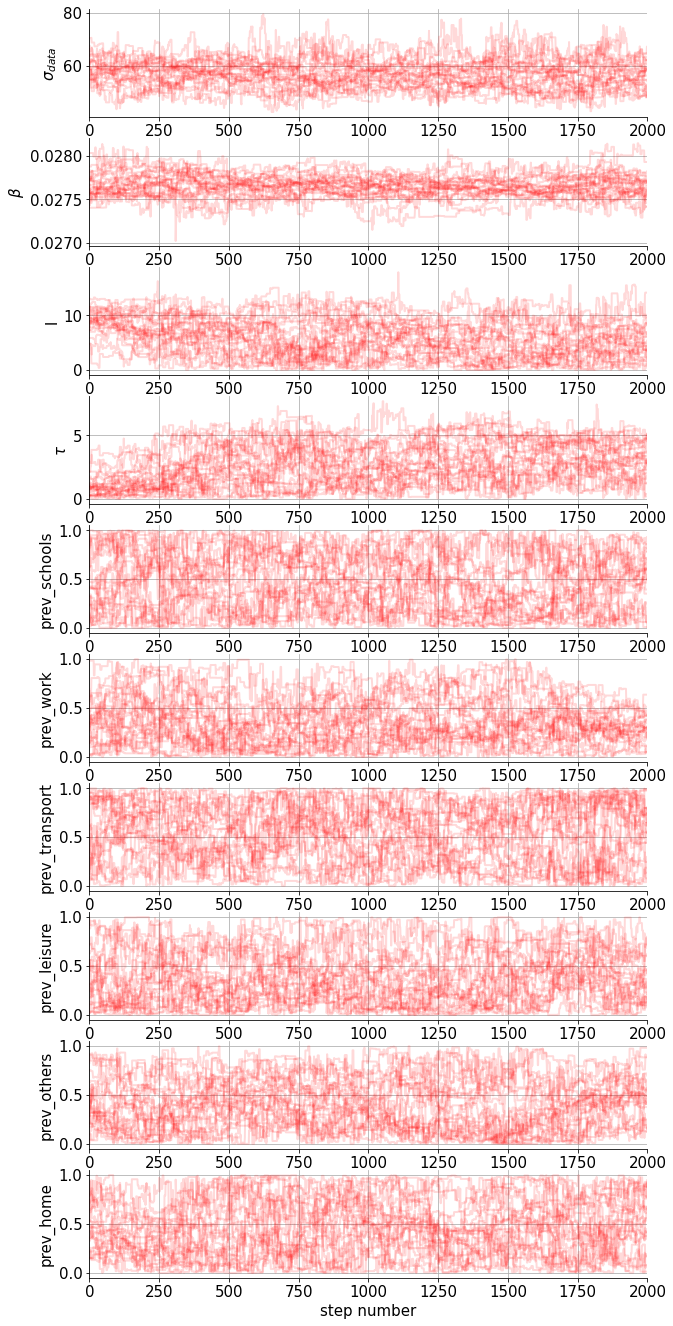

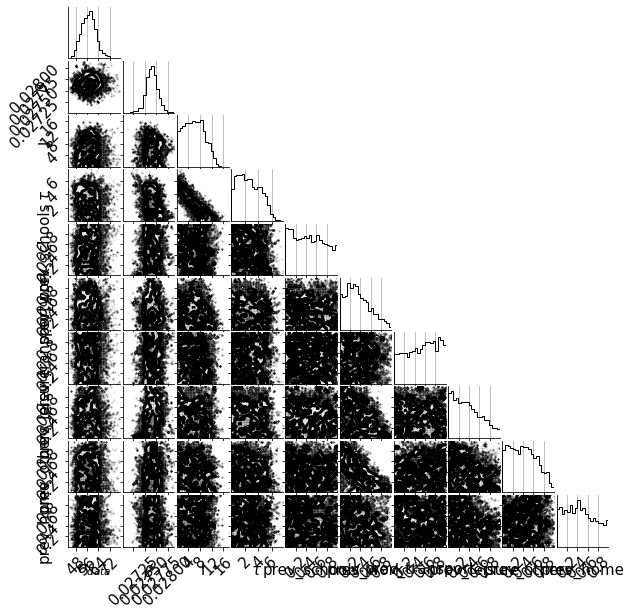

In [21]:
warmup=0
maxiter = 100
popsize = 100
steps_mcmc = 3000
discard = 1000
processes = 16 # voor eraser!!

# define dataset
data=[df_sciensano['H_in'][start_calibration:end_calibration]]
states = [["H_in"]]

####################################################
####### CALIBRATING BETA AND COMPLIANCE RAMP #######
####################################################

print('------------------------------------')
print('CALIBRATING BETA AND COMPLIANCE RAMP')
print('------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization\n')

# set PSO optimisation settings
parNames = ['sigma_data','beta','l','tau',
            'prev_schools', 'prev_work', 'prev_transport', 'prev_leisure', 'prev_others', 'prev_home']
bounds=((1,2000),(0.010,0.060),(0.1,20),(0.1,20),
        (0,1),(0,1),(0,1),(0,1),(0,1),(0,1))

# run PSO optimisation
theta = pso.fit_pso(model,data,parNames,states,bounds,maxiter=maxiter,popsize=popsize,
                    start_date=start_calibration,warmup=warmup, processes=processes) ## PROCESSES=1 to debug!

# run MCMC sampler
print('\n2) Markov-Chain Monte-Carlo sampling\n')
parNames_mcmc = parNames
bounds_mcmc=((1,2000),(0.020,0.060),(0.001,20),(0.001,20),
             (0,1),(0,1),(0,1),(0,1),(0,1),(0,1))

pos = theta + [1, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3]* np.random.randn(22, 10)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                    args=(model, bounds_mcmc, data, states, parNames_mcmc, None, start_calibration, warmup))
sampler.run_mcmc(pos, steps_mcmc, progress=True)

try:
    sampler.get_autocorr_time()
except:
    print('Warning: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s).\nUse this estimate with caution and run a longer chain!')
from covid19model.optimization.run_optimization import checkplots
checkplots(sampler.get_chain(discard=discard,flat=False), sampler.get_chain(discard=discard,flat=True), fig_path, spatial_unit, 
            figname='BETA_RAMP_GOOGLE_WAVE2', labels=['$\sigma_{data}$','$\\beta$','l','$\\tau$',
                                                      'prev_schools', 'prev_work', 'prev_transport', 
                                                      'prev_leisure', 'prev_others', 'prev_home'])

#############################################
####### Output to dictionary ################
#############################################

samples_dict_wave2 = {
    'beta': sampler.get_chain(discard=discard,flat=True)[:,1].tolist(),
    'l' : sampler.get_chain(discard=discard,flat=True)[:,2].tolist(),
    'tau' : sampler.get_chain(discard=discard,flat=True)[:,3].tolist(),
    'prev_schools': sampler.get_chain(discard=discard,flat=True)[:,4].tolist(),
    'prev_work': sampler.get_chain(discard=discard,flat=True)[:,4].tolist(),
    'prev_transport': sampler.get_chain(discard=discard,flat=True)[:,4].tolist(),
    'prev_leisure': sampler.get_chain(discard=discard,flat=True)[:,4].tolist(),
    'prev_others': sampler.get_chain(discard=discard,flat=True)[:,4].tolist(),
    'prev_home': sampler.get_chain(discard=discard,flat=True)[:,4].tolist(),
    'calibration_data' : states[0][0],
    'start_date' : start_calibration,
    'end_date' : end_calibration,
    'maxiter' : maxiter,
    'popsize': popsize,
    'steps_mcmc': steps_mcmc,
    'discard' : discard,

}

with open(samples_path+str(spatial_unit)+'_'+str(datetime.date.today())+'_WAVE2_GOOGLE.json', 'w') as fp:
    json.dump(samples_dict_wave2, fp)

## Visualize fit

In [ ]:
model.parameters.keys()

(array([5627., 5078., 4331., 4660., 4712., 4138., 4560., 3885., 3628.,
        3381.]),
 array([2.13466907e-04, 1.00180389e-01, 2.00147311e-01, 3.00114233e-01,
        4.00081155e-01, 5.00048077e-01, 6.00014999e-01, 6.99981921e-01,
        7.99948843e-01, 8.99915765e-01, 9.99882687e-01]),
 <BarContainer object of 10 artists>)

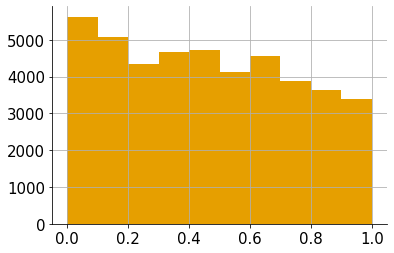

In [22]:
fig,ax = plt.subplots()
plt.hist(samples_dict_wave2['prev_leisure'])

**figuur opnieuw runnen na uitgebreide MCMC!**

(18506.0, 18628.0)

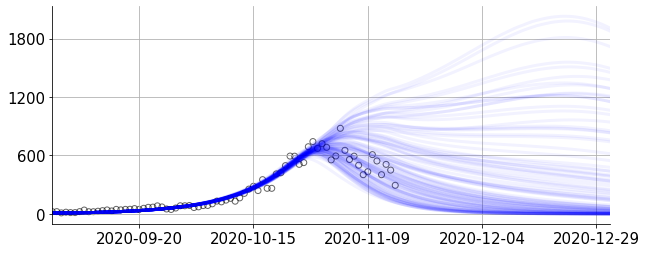

In [24]:
end_sim = '2021-01-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(100):
    # Sampling
    idx, model.parameters['beta'] = random.choice(list(enumerate(samples_dict_wave2['beta'])))
    model.parameters['l'] = samples_dict_wave2['l'][idx] 
    model.parameters['tau'] = samples_dict_wave2['tau'][idx]    
    model.parameters['prev_schools'] = samples_dict_wave2['prev_schools'][idx]    
    model.parameters['prev_work'] = samples_dict_wave2['prev_work'][idx]     
    model.parameters['prev_transport'] = samples_dict_wave2['prev_transport'][idx]    
    model.parameters['prev_leisure'] = samples_dict_wave2['prev_leisure'][idx]     
    model.parameters['prev_others'] = samples_dict_wave2['prev_others'][idx]      

    # Simulate
    y_model = model.sim(end_sim,start_date=start_calibration,warmup=0)
    # Plot
    ax.plot(y_model['time'],y_model["H_in"].sum(dim="Nc"),color='blue',alpha=0.05)

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)
#plt.savefig(fig_path+'others/FIT_WAVE2_GOOGLE_'+spatial_unit+'_'+str(datetime.date.today())+'.pdf', dpi=400, bbox_inches='tight')

In [25]:
plt.savefig(fig_path+'others/FIT_WAVE2_GOOGLE_'+spatial_unit+'_more_mcmc_'+str(datetime.date.today())+'.pdf', dpi=400, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

## Make a prediction under current contact behaviour

In [ ]:
end_sim = '2021-02-01'
n=200
percentile = 0.95

y_model = model.sim(end_sim,start_date=start_calibration,warmup=0,N=n,draw_fcn=draw_sample_COVID19_SEIRD_google,samples=samples_dict_wave2)

fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model['time'].values),y_model["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"), y_model["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.20, color = 'blue')
ax.fill_between(pd.to_datetime(y_model['time'].values),y_model["H_tot"].quantile(1-0.68,dim="draws").sum(dim="Nc"), y_model["H_tot"].quantile(0.68,dim="draws").sum(dim="Nc"),alpha=0.35, color = 'blue')
ax.plot(y_model['time'],y_model["H_tot"].mean(dim="draws").sum(dim="Nc"),'--', color='blue')
ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_tot'][start_calibration:end_calibration],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax.set_ylabel('Total patients in Belgian hospitals')
ax = _apply_tick_locator(ax)
plt.savefig(fig_path+'others/LOCKDOWN_WAVE2_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')